# Bodo Extended Tutorial

This is a continuation of the "Getting Started" tutorial. You are encouraged to visit that tutorial first if you have not done so already. In this tutorial, we will explain core Bodo concepts in more detail, introduce additional Bodo features, and discuss more advanced topics.

## Environment Setup

Please follow the [Bodo installation](http://docs.bodo.ai/latest/source/install.html) and [Jupyter Notebook Setup](http://docs.bodo.ai/latest/source/jupyter.html) pages to setup the environment. Also, make sure MPI engines are started in the `IPython Clusters` tab (or using `ipcluster start -n 4 --profile=mpi` in command line).

## Bodo Basics

### JIT (Just-in-time) Compilation Workflow

Bodo provides a just-in-time (JIT) compilation workflow using the `@bodo.jit` decorator, which replaces a Python function with a so-called `Dispatcher` object. Bodo compiles the function the first time a Dispatcher object is called and reuses the compiled version afterwards. The function is recompiled only if the same function is called with different argument types (not often in practice).

In [1]:
import numpy as np
import pandas as pd
import bodo

@bodo.jit
def f(n, a):
    df = pd.DataFrame({'A': np.arange(n) + a})
    return df.head(3)

print(f)
print(f(8, 1))  # compiles for (int, int) input types
print(f(8, 2))  # same input types, no need to compile
print(f(8, 2.2))  # compiles for (int, float) input types

CPUDispatcher(<function f at 0x1204ab160>)
   A
0  1
1  2
2  3
   A
0  2
1  3
2  4
     A
0  2.2
1  3.2
2  4.2


All of this is completely transparent to the caller, and does not affect any Python code calling the function.

<div class="alert alert-block alert-info"
<b>Note:</b>
In many cases, the binary that Bodo generates when compiling a function can be saved to disk to be reused across program executions. See "Bodo Caching" below for more information.

</div>



### Parallel Execution Model

As we saw in the "Getting Started" tutorial, Bodo transforms functions for parallel execution. However, the dispatcher does not launch processes or threads on the fly. Instead, the Python application (including non-Bodo code) is intended to be executed under an MPI Single Program Multiple Data ([SPMD](https://en.wikipedia.org/wiki/SPMD)) paradigm, where MPI processes are launched in the beginning and all run the same code.


For example, we can save an example code in a file and use *mpiexec* to launch 4 processes:

In [ ]:
import numpy as np
import pandas as pd
import bodo

@bodo.jit(distributed=["df"])
def f(n, a):
    df = pd.DataFrame({'A': np.arange(n) + a})
    return df

print(f(8, 1))

In [ ]:
%save -f test_bodo.py 2 # cell number of previous cell

In [4]:
!mpiexec -n 4 python test_bodo.py

   A
2  3
3  4
   A
4  5
5  6
   A
0  1
1  2
   A
6  7
7  8


In this example, `mpiexec` launches 4 Python processes, each of which executes the same `test_bodo.py` file.

<div class="alert alert-block alert-warning"
<b>Important:</b>

- Python codes outside of Bodo functions execute sequentially on every process.
- Bodo functions run in parallel assuming that Bodo is able to parallelize them. Otherwise, they also run sequentially on every process. Bodo warns if it does not find parallelism (more details later).

</div>

Note how the prints, which are regular Python code executed outside of Bodo, run for each process.

On Jupyter notebook, parallel execution happens in very much the same way. We start a set of MPI engines through `ipyparallel` and activate a client:

In [2]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')
view = c[:]
view.activate()

After this initialization, any code that we run in the notebook with `%%px --block` is sent for execution on all MPI engines.

In [3]:
%%px --block

import numpy as np
import pandas as pd
import bodo

@bodo.jit(distributed=['df'])
def f(n):
    df = pd.DataFrame({'A': np.arange(n)})
    return df

print(f(8))

[stdout:0] 
   A
0  0
1  1
[stdout:1] 
   A
2  2
3  3
[stdout:2] 
   A
4  4
5  5
[stdout:3] 
   A
6  6
7  7


### Parallel APIs

Bodo provides a limited number of parallel APIs to support advanced cases that may need them. The example below demonstrates getting the process number from Bodo (called `rank` in MPI terminology), getting total number of processes, and synchronizing all processes.

In [8]:
%%px --block

# some work only on rank 0
if bodo.get_rank() == 0:
    print("rank 0 done")


print("rank", bodo.get_rank(), "here")
print("total ranks:", bodo.get_size())

[stdout:0] 
rank 0 done
rank 0 here
total ranks: 4
[stdout:1] 
rank 1 here
total ranks: 4
[stdout:2] 
rank 2 here
total ranks: 4
[stdout:3] 
rank 3 here
total ranks: 4


A common pattern is using barriers to make sure all processes see side-effects at the same time. For example, a process can delete files from storage while others wait before writing to file:

In [9]:
%%px --block
import shutil, os
import numpy as np

# remove file if exists
if bodo.get_rank() == 0:
    if os.path.exists("data.pq"):
        shutil.rmtree("data.pq")

# make sure all processes are synchronized
# (e.g. all processes need to see effect of rank 0's work)
bodo.barrier()

@bodo.jit
def f(n):
    df = pd.DataFrame({"A": np.arange(n)})
    df.to_parquet("data.pq")

<div class="alert alert-block alert-danger"
<b>Important:</b> As in this example, it is possible to have each process follow a different control flow, but all processes must always call the same Bodo functions in the same order.
</div>

## Data Distribution

Bodo parallelizes computation by dividing data into separate chunks across processes. However, some data handled by a Bodo function may not be divided into chunks. There are are two main data distribution schemes:

- Replicated (*REP*): the data associated with the variable is the same on every process.
- One-dimensional (*1D*): the data is divided into chunks, split along one dimension (rows of a dataframe or first dimension of an array).

Bodo determines distribution of variables automatically, using the nature of the computation that produces them. Let's see an example:

In [10]:
%%px --block

@bodo.jit
def mean_power_speed():
    df = pd.read_parquet('cycling_dataset.pq')
    m = df[["power", "speed"]].mean()
    return m

res = mean_power_speed()
print(res)

[stdout:0] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:1] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:2] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:3] 
power    102.078421
speed      5.656851
dtype: float64


In this example, `df` is parallelized (each process reads a different chunk) but `m` is replicated, even though it is a Series. Semantically, it makes sense for the output of `mean` operation to be replicated on all processors, since it is a reduction and produces "small" data.

### Distributed Diagnostics

The distributions found by Bodo can be printed either by setting the environment variable `BODO_DISTRIBUTED_DIAGNOSTICS=1` or calling `distributed_diagnostics()` on the compiled function. Let's examine the previous example's distributions:

In [11]:
%%px --block
mean_power_speed.distributed_diagnostics()

[stdout:0] 
Distributed diagnostics for function mean_power_speed, <ipython-input-15-b6752a146201> (1)

Data distributions:
   power.5929                1D_Block
   speed.5930                1D_Block
   $A.6145.6484              1D_Block
   $A.6208.6494              1D_Block
   $data.6117.6505           REP
   $12call_method.5.6468     REP
   $66call_method.31.6135    REP
   $m.6507                   REP
   $30return_value.12        REP

Parfor distributions:
   20                   1D_Block
   21                   1D_Block

Distributed listing for function mean_power_speed, <ipython-input-15-b6752a146201> (1)
--------------------------------------------------| parfor_id/variable: distribution
@bodo.jit                                         | 
def mean_power_speed():                           | 
    df = pd.read_parquet('cycling_dataset.pq')----| power.5929: 1D_Block, speed.5930: 1D_Block
    m = df[["power", "speed"]].mean()-------------| $A.6145.6484: 1D_Block, $A.6208.6494: 1D_Blo

Variables are renamed due to optimization. The output shows that `power` and `speed` columns of `df` are distributed (`1D_Block`) but `m` is replicated (`REP`). This is because `df` is output of `read_parquet` and input of `mean`, both of which can be distributed by Bodo. `m` is output of `mean`, which is always replicated (available on every process).

### Function Arguments and Return Values

Now let's see what happens if we pass the data into the Bodo function as a function parameter but don't mark it as distributed:

In [12]:
%%px --block

@bodo.jit
def mean_power_speed(df):
    m = df[["power", "speed"]].mean()
    return m

df = pd.read_parquet('cycling_dataset.pq')
res = mean_power_speed(df)
print(res)

[stdout:0] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:1] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:2] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:3] 
power    102.078421
speed      5.656851
dtype: float64


[stderr:0] 
/bodo/bodo/transforms/distributed_analysis.py:229: BodoWarning: No parallelism found for function 'mean_power_speed'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(


The program runs and returns the same correct value as before, but everything is replicated on all processes and *there is no parallelism!* Bodo's warning indicates this explicitly. Therefore, each process reads the whole data file and calculates the mean of the dataframe independently.

This is because data is passed to Bodo as argument without setting the `distributed` flag, and Bodo assumes correctly that the data is replicated (note that the dataframe in this case is read using pandas). Bodo then follows dependencies and replicates the whole program.

Similarly, return values will be replicated by default, since data is passed to regular Python:

In [4]:
%%px --block
import bodo
import pandas as pd

pd.options.display.max_columns = 7

@bodo.jit
def mean_power_speed():
    df = pd.read_parquet('cycling_dataset.pq')
    return df

df = mean_power_speed()
print(df)

[stdout:0] 
      Unnamed: 0    altitude  cadence  ...  power  speed                time
0              0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
1              1  185.800003       68  ...      0  3.710 2016-10-20 22:01:27
2              2  186.399994       38  ...     42  3.874 2016-10-20 22:01:28
3              3  186.800003       38  ...      5  4.135 2016-10-20 22:01:29
4              4  186.600006       38  ...      1  4.250 2016-10-20 22:01:30
...          ...         ...      ...  ...    ...    ...                 ...
3897        1127  178.199997        0  ...      0  3.497 2016-10-20 23:14:31
3898        1128  178.199997        0  ...      0  3.289 2016-10-20 23:14:32
3899        1129  178.199997        0  ...      0  2.969 2016-10-20 23:14:33
3900        1130  178.399994        0  ...      0  2.969 2016-10-20 23:14:34
3901        1131  178.399994        0  ...      0  2.853 2016-10-20 23:14:35

[3902 rows x 10 columns]
[stdout:1] 
      Unnamed: 0    altitu

[stderr:0] 
/Users/ehsan/dev/bodo/bodo/transforms/distributed_analysis.py:229: BodoWarning: No parallelism found for function 'mean_power_speed'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(


<div class="alert alert-block alert-warning"
<b>Important:</b> Bodo assumes that input parameters and return values are replicated, unless if specified using `distributed` flag. This can lead to replication of the whole program due to dependencies.
</div>

### Passing Distributed Data to Bodo

Bodo functions may require distributed arguments and return values in some cases such as passing distributed data across Bodo functions. This can be achieved using the `distributed` flag:

In [14]:
%%px --block

@bodo.jit(distributed=['df'])
def read_data():
    df = pd.read_parquet('cycling_dataset.pq')
    print("total size", len(df))
    return df

@bodo.jit(distributed=['df'])
def mean_power(df):
    x = df.power.mean()
    return x

df = read_data()
# df is a chunk of data on each process
print("chunk size", len(df))
res = mean_power(df)
print(res)

[stdout:0] 
total size 3902
chunk size 976
102.07842132239877
[stdout:1] 
chunk size 976
102.07842132239877
[stdout:2] 
chunk size 975
102.07842132239877
[stdout:3] 
chunk size 975
102.07842132239877


### Scattering Data

One can distribute data manually by *scattering* data from one process to all processes. For example:

In [15]:
%%px --block

@bodo.jit(distributed=['df'])
def mean_power(df):
    x = df.power.mean()
    return x

df = None
# only rank 0 reads the data
if bodo.get_rank() == 0:
    df = pd.read_parquet('cycling_dataset.pq')

df = bodo.scatterv(df)
res = mean_power(df)
print(res)

[stdout:0] 102.07842132239877
[stdout:1] 102.07842132239877
[stdout:2] 102.07842132239877
[stdout:3] 102.07842132239877


### Gathering Data

One can *gather* distributed data into a single process manually. For example:

In [5]:
%%px --block

@bodo.jit
def mean_power():
    df = pd.read_parquet('cycling_dataset.pq')
    return bodo.gatherv(df)

df = mean_power()
print(df)

[stdout:0] 
      Unnamed: 0    altitude  cadence  ...  power  speed                time
0              0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
1              1  185.800003       68  ...      0  3.710 2016-10-20 22:01:27
2              2  186.399994       38  ...     42  3.874 2016-10-20 22:01:28
3              3  186.800003       38  ...      5  4.135 2016-10-20 22:01:29
4              4  186.600006       38  ...      1  4.250 2016-10-20 22:01:30
...          ...         ...      ...  ...    ...    ...                 ...
3897        1127  178.199997        0  ...      0  3.497 2016-10-20 23:14:31
3898        1128  178.199997        0  ...      0  3.289 2016-10-20 23:14:32
3899        1129  178.199997        0  ...      0  2.969 2016-10-20 23:14:33
3900        1130  178.399994        0  ...      0  2.969 2016-10-20 23:14:34
3901        1131  178.399994        0  ...      0  2.853 2016-10-20 23:14:35

[3902 rows x 10 columns]
[stdout:1] 
Empty DataFrame
Columns: [

Alternatively, distributed data can be gathered and sent to all processes, effectively replicating the data:

In [6]:
%%px --block

@bodo.jit
def mean_power():
    df = pd.read_parquet('cycling_dataset.pq')
    return bodo.allgatherv(df)

df = mean_power()
print(df)

[stdout:0] 
      Unnamed: 0    altitude  cadence  ...  power  speed                time
0              0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
1              1  185.800003       68  ...      0  3.710 2016-10-20 22:01:27
2              2  186.399994       38  ...     42  3.874 2016-10-20 22:01:28
3              3  186.800003       38  ...      5  4.135 2016-10-20 22:01:29
4              4  186.600006       38  ...      1  4.250 2016-10-20 22:01:30
...          ...         ...      ...  ...    ...    ...                 ...
3897        1127  178.199997        0  ...      0  3.497 2016-10-20 23:14:31
3898        1128  178.199997        0  ...      0  3.289 2016-10-20 23:14:32
3899        1129  178.199997        0  ...      0  2.969 2016-10-20 23:14:33
3900        1130  178.399994        0  ...      0  2.969 2016-10-20 23:14:34
3901        1131  178.399994        0  ...      0  2.853 2016-10-20 23:14:35

[3902 rows x 10 columns]
[stdout:1] 
      Unnamed: 0    altitu

## Parallel I/O

![Bodo reads file chunks in parallel](img/file-read.jpg)

Efficient parallel data processing requires data I/O to be parallelized effectively as well. Bodo provides parallel file I/O for many different formats such as [Parquet](http://parquet.apache.org),
CSV, JSON, Numpy binaries, [HDF5](http://www.h5py.org) and SQL databases. This diagram demonstrates how chunks of data are partitioned among parallel execution engines by Bodo.

### Parquet

Parquet is a commonly used file format in analytics due to its efficient columnar storage. Bodo supports the standard pandas API for reading Parquet:

In [7]:
%%px --block
import pandas as pd
import bodo

@bodo.jit(distributed=['df'])
def pq_read():
    df = pd.read_parquet('cycling_dataset.pq')
    return df

# on each process, this returns the data chunk read by that process
res = pq_read()
if bodo.get_rank() == 0:
    print(res)  # display results of first process only

[stdout:0] 
     Unnamed: 0    altitude  cadence  ...  power  speed                time
0             0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
1             1  185.800003       68  ...      0  3.710 2016-10-20 22:01:27
2             2  186.399994       38  ...     42  3.874 2016-10-20 22:01:28
3             3  186.800003       38  ...      5  4.135 2016-10-20 22:01:29
4             4  186.600006       38  ...      1  4.250 2016-10-20 22:01:30
..          ...         ...      ...  ...    ...    ...                 ...
971         971  132.399994        0  ...      1  4.385 2016-10-20 22:20:32
972         972  132.199997        0  ...      1  4.122 2016-10-20 22:20:33
973         973  132.199997        0  ...    283  4.715 2016-10-20 22:20:34
974         974  132.399994       70  ...     98  5.161 2016-10-20 22:20:35
975         975  132.399994      115  ...      1  5.155 2016-10-20 22:20:36

[976 rows x 10 columns]


Bodo also supports the pandas API for writing Parquet files:

In [19]:
%%px --block
import numpy as np
import pandas as pd
import bodo

@bodo.jit
def generate_data_and_write():
    df = pd.DataFrame({"A": np.arange(80)})
    df.to_parquet("pq_output.pq")

generate_data_and_write()

<div class="alert alert-block alert-info"
<b>Note:</b> Bodo writes a directory of parquet files (one file per process) when writing distributed data. Bodo writes a single file when the data is replicated.
</div>

In this example, `df` is distributed data so it is written to a directory a parquet files.

Bodo supports parallel read of single Parquet files, as well as directory of files:

In [20]:
%%px --block
import pandas as pd
import bodo

@bodo.jit(distributed=['df'])
def read_parquet_dir():
    df = pd.read_parquet("pq_output.pq")
    return df

df = read_parquet_dir()
print(df)

[stdout:0] 
     A
0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
10  10
11  11
12  12
13  13
14  14
15  15
16  16
17  17
18  18
19  19
[stdout:1] 
     A
20  20
21  21
22  22
23  23
24  24
25  25
26  26
27  27
28  28
29  29
30  30
31  31
32  32
33  33
34  34
35  35
36  36
37  37
38  38
39  39
[stdout:2] 
     A
40  40
41  41
42  42
43  43
44  44
45  45
46  46
47  47
48  48
49  49
50  50
51  51
52  52
53  53
54  54
55  55
56  56
57  57
58  58
59  59
[stdout:3] 
     A
60  60
61  61
62  62
63  63
64  64
65  65
66  66
67  67
68  68
69  69
70  70
71  71
72  72
73  73
74  74
75  75
76  76
77  77
78  78
79  79


### CSV
CSV is a common text format for data exchange. Bodo supports the standard pandas API to read CSV files:

In [8]:
%%px --block
import pandas as pd
import bodo

@bodo.jit(distributed=['df'])
def csv_example():
    df = pd.read_csv('cycling_dataset.csv', header=None)
    return df

res = csv_example()
if bodo.get_rank() == 0:
    print(res)

[stdout:0] 
       0    1           2  ...    8      9                   10
0      0    0  185.800003  ...   45  3.459  2016-10-20 22:01:26
1      1    1  185.800003  ...    0  3.710  2016-10-20 22:01:27
2      2    2  186.399994  ...   42  3.874  2016-10-20 22:01:28
3      3    3  186.800003  ...    5  4.135  2016-10-20 22:01:29
4      4    4  186.600006  ...    1  4.250  2016-10-20 22:01:30
..   ...  ...         ...  ...  ...    ...                  ...
971  971  971  132.399994  ...    1  4.385  2016-10-20 22:20:32
972  972  972  132.199997  ...    1  4.122  2016-10-20 22:20:33
973  973  973  132.199997  ...  283  4.715  2016-10-20 22:20:34
974  974  974  132.399994  ...   98  5.161  2016-10-20 22:20:35
975  975  975  132.399994  ...    1  5.155  2016-10-20 22:20:36

[976 rows x 11 columns]


In addition to the pandas `read_csv()` functionality, Bodo can also read a directory containing multiple CSV files (all part of the same dataframe).

<div class="alert alert-block alert-info"
<b>Note:</b>

When writing distributed data to CSV:

- To S3 or HDFS: Bodo writes to a directory of CSV files (one file per process)
- To POSIX filesystem (e.g. local filesystem on Linux): Bodo writes the distributed data in parallel to a single file.

If the data is replicated, Bodo always writes to a single file.

</div>

### HDF5
HDF5 is a common format in scientific computing, especially for multi-dimensional numerical data. HDF5 can be very efficient at scale, since it has native parallel I/O support. Bodo supports the standard h5py APIs:

In [22]:
%%px --block
import h5py

@bodo.jit
def example_h5():
    f = h5py.File("data.h5", "r")
    return f['A'][:].sum()

res = example_h5()
if bodo.get_rank() == 0: print(res)

[stdout:0] 66


### Numpy Binary Files
Bodo supports reading and writing binary files using Numpy APIs as well.

In [23]:
%%px --block

@bodo.jit
def example_np_io():
    A = np.fromfile("data.dat", np.int64)
    return A.sum()

res = example_np_io()
if bodo.get_rank() == 0: print(res)

[stdout:0] 45


### Type Annotation (when file name is unknown at compile time)

Bodo needs to know or infer the types for all data, but this is not always possible for input from files if file name is not known at compilation time.

For example, suppose we have the following files:

In [24]:
import pandas as pd
import numpy as np

def generate_files(n):
    for i in range(n):
        df = pd.DataFrame({"A": np.arange(5, dtype=np.int64)})
        df.to_parquet("test" + str(i) + ".pq")

generate_files(5)

And we want to read them like this:

In [25]:
import pandas as pd
import numpy as np
import bodo

@bodo.jit
def read_data(n):
    x = 0
    for i in range(n):
        file_name = "test" + str(i) + ".pq"
        df = pd.read_parquet(file_name)
        print(df)
        x += df["A"].sum()
    return x

result = read_data(5)
# BodoError: Parquet schema not available. Either path argument should be
# constant for Bodo to look at the file at compile time or schema should be provided.

BodoError: Parquet schema not available. Either path argument should be constant for Bodo to look at the file at compile time or schema should be provided.

The file names are computed at runtime, which doesn't allow the compiler to find the files and extract the schemas. As shown below, the solution is to use *type annotation* to provide data types to the compiler.

#### Type annotation for Parquet files

Example below uses the `locals` option of the decorator to provide the compiler with the schema of the local variable `df`:

In [26]:
%%px --block
import pandas as pd
import numpy as np
import bodo

@bodo.jit(locals={"df": {"A": bodo.int64[:]}})
def read_data(n):
    x = 0
    for i in range(n):
        file_name = "test" + str(i) + ".pq"
        df = pd.read_parquet(file_name)
        x += df["A"].sum()
    return x

result = read_data(5)
if bodo.get_rank() == 0:
    print(result)

[stdout:0] 50


#### Type annotation for CSV files

For CSV files, we can annotate types in the same way as pandas:

In [28]:
%%px --block
import pandas as pd
import numpy as np
import bodo

def generate_files(n):
    for i in range(n):
        df = pd.DataFrame({"A": np.arange(5, dtype=np.int64)})
        df.to_csv("test" + str(i) + ".csv", index=False)

@bodo.jit
def read_data(n):
    coltypes = {'A': np.int64}
    x = 0
    for i in range(n):
        file_name = "test" + str(i) + ".csv"
        df = pd.read_csv(file_name, names=coltypes.keys(), dtype=coltypes, header=0)
        x += df["A"].sum()
    return x

n = 5
if bodo.get_rank() == 0:
    generate_files(n)
bodo.barrier()
result = read_data(n)
if bodo.get_rank() == 0:
    print(result)

[stdout:0] 50


## Bodo Caching

In many situations, Bodo can save the binary resulting from the compilation of a function to disk, to be reused in future runs. This avoids the need to recompile functions the next time that you run your application.

As we explained earlier, recompiling a function is only necessary when it is called with new input types, and the same applies to caching. In other words, an application can be run multiple times and process different data without having to recompile any code if the data types remain the same (which is the most common situation).

<div class="alert alert-block alert-warning"
<b>Warning:</b> Caching works in many (but not all) situations, and is disabled by default. See caching limitations below for more information.
</div>

### Caching Example

To cache a function, we only need to add the option `cache=True` to the JIT decorator:

In [19]:
%%px --block
import time

@bodo.jit(cache=True)
def mean_power_speed():
    df = pd.read_parquet('cycling_dataset.pq')
    return df[["power", "speed"]].mean()

t0 = time.time()
result = mean_power_speed()
if bodo.get_rank() == 0:
    print(result)
    print("Total execution time:", round(time.time() - t0, 3), "secs")

[stdout:0] 
power    102.078421
speed      5.656851
dtype: float64
Total execution time: 0.013 secs


The first time that the above code runs, Bodo compiles the function and caches it to disk. In subsequent runs, it will recover the function from cache and the execution time will be much faster as a result. You can try this out by running the above code multiple times, and changing between `cache=True` and `cache=False`.

### Cache Location and Portability

In most cases, the cache is saved in the `__pycache__` directory inside the directory where the source files are located.

On Jupyter notebooks, the cache directory is called ``numba_cache`` and is located in ``IPython.paths.get_ipython_cache_dir()``. See [here](http://numba.pydata.org/numba-doc/latest/reference/envvars.html?#envvar-NUMBA_CACHE_DIR) for more information on these and other alternate cache locations. For example, when running in a notebook:

In [13]:
import os
import IPython

cache_dir = IPython.paths.get_ipython_cache_dir() + "/numba_cache"
print("Cache files:")
os.listdir(cache_dir)

Cache files:


['ipython-input-10825d883f44.mean_power_speed-4444615264.py38.1.nbc',
 'ipython-input-10825d883f44.mean_power_speed-4444615264.py38.nbi']

Cached objects work across systems with the same CPU model and CPU features. Therefore, it is safe to share and reuse the contents in the cache directory on a different machine. See [here](http://numba.pydata.org/numba-doc/latest/developer/caching.html#cache-sharing) for more information.

### Cache Invalidation

The cache is invalidated automatically when the corresponding source code is modified. One way to observe this behavior is to modify the above example after it has been cached a first time, by changing the name of the variable `df`. The next time that we run the code, Bodo will determine that the source code has been modified, invalidate the cache and recompile the function.

<div class="alert alert-block alert-warning"
<b>Warning:</b> It is sometimes necessary to clear the cache manually (see caching limitations below). To clear the cache, the cache files can simply be removed.
</div>

### Current Caching Limitations

- Caching does not recognize changes in Bodo versions, and cached files from different versions may not work, thus requiring manual clearing of the cache.
- Changes in compiled functions are not seen across files. For example, if we have a cached Bodo function that calls a cached Bodo function in a different file, and modify the latter, Bodo will not update its cache (and therefore run with the old version of the function).
- Functions that use `objmode` cannot be cached.
- Global variables are treated as compile-time constants. When a function is compiled, the value of any globals that the function uses are embedded in the binary at compilation time and remain constant. If the value of the global changes in the source code after compilation, the compiled object (and cache) will not rebind to the new value.

## Advanced Features

### Explicit Parallel Loops
Sometimes explicit parallel loops are required since a program cannot be written in terms of data-parallel operators easily. In this case, one can use Bodo’s `prange` in place of `range` to specify that a loop can be parallelized. The user is required to make sure the loop does not have cross iteration dependencies except for supported reductions.

The example below demonstrates a parallel loop with a reduction:

In [29]:
%%px --block
import bodo
from bodo import prange
import numpy as np

@bodo.jit
def prange_test(n):
    A = np.random.ranf(n)
    s = 0
    B = np.empty(n)
    for i in prange(len(A)):
        bodo.parallel_print("rank", bodo.get_rank())
        # A[i]: distributed data access with loop index
        # s: a supported sum reduction
        s += A[i]
        # write array with loop index
        B[i] = 2 * A[i]
    return s + B.sum()

res = prange_test(10)
print(res)

[stdout:0] 
rank 0
rank 0
rank 0
19.593985614757415
[stdout:1] 
rank 1
rank 1
rank 1
19.593985614757415
[stdout:2] 
rank 2
rank 2
19.593985614757415
[stdout:3] 
rank 3
rank 3
19.593985614757415


Currently, reductions using +=, *=, min, and max operators are supported. Iterations are simply divided between processes and executed in parallel, but reductions are handled using data exchange.

### Integration with non-Bodo APIs
There are multiple methods for integration with APIs that Bodo does not support natively:
1. Switch to python object mode inside jit functions
2. Pass data in and out of jit functions

#### Object mode
Object mode allows switching to a python intepreted context to be able to run non-jittable code. The main requirement is specifying the type of returned values. For example, the following code calls a Scipy function on data elements of a distributed dataset:

In [30]:
%%px --block
import scipy.special as sc

@bodo.jit
def objmode_test(n):
    A = np.random.ranf(n)
    s = 0
    for i in prange(len(A)):
        x = A[i]
        with bodo.objmode(y="float64"):
            y = sc.entr(x)  # call entropy function on each data element
        s += y
    return s

res = objmode_test(10)
print(res)

[stdout:0] 2.5130300167369066
[stdout:1] 2.5130300167369066
[stdout:2] 2.5130300167369066
[stdout:3] 2.5130300167369066


See Numba's documentation for [objmode](http://numba.pydata.org/numba-doc/latest/user/withobjmode.html#the-objmode-context-manager) for more details.

#### Passing Distributed Data
Bodo can receive or return chunks of distributed data to allow flexible integration with any non-Bodo Python code. The following example passes chunks of data to interpolate with Scipy, and returns interpolation results back to jit function.

In [31]:
%%px --block
import scipy.interpolate

@bodo.jit(distributed=["X", "Y", "X2"])
def dist_pass_test(n):
    X = np.arange(n)
    Y = np.exp(-X/3.0)
    X2 = np.arange(0, n, 0.5)
    return X, Y, X2

X, Y, X2 = dist_pass_test(100)
# clip potential out-of-range values
X2 = np.minimum(np.maximum(X2, X[0]), X[-1])
f = scipy.interpolate.interp1d(X, Y)
Y2 = f(X2)

@bodo.jit(distributed={'Y2'})
def dist_pass_res(Y2):
    return Y2.sum()

res = dist_pass_res(Y2)
print(res)

[stdout:0] 6.555500504321469
[stdout:1] 6.555500504321469
[stdout:2] 6.555500504321469
[stdout:3] 6.555500504321469


### Visualization
A simple approach for visualization is pulling data to the notebook process from execution engines and using Python visualization libraries. Distributed data can be gathered if there is enough memory on the local machine. Otherwise, a sample of data can be gathered. The example code below demonstrates gathering a portion of data for visualization:

In [32]:
%%px --block

@bodo.jit
def dist_gather_test(n):
    X = np.arange(n)
    Y = np.exp(-X/3.0)
    return bodo.gatherv(Y[::10])  # gather every 10th element


Y_sample = dist_gather_test(100)


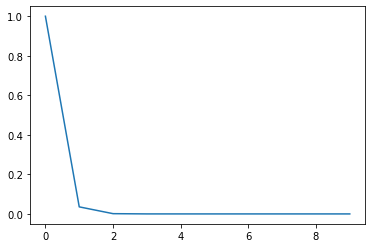

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

Y_sample = view['Y_sample'][0]
plt.plot(Y_sample)

## Troubleshooting

### Compilation Tips

The general recommendation is to **compile the code that is performance critical and/or requires scaling**.

1. Don’t use Bodo for scripts that set up infrastucture or do initializations.
2. Only use Bodo for data processing and analytics code.

This reduces the risk of hitting unsupported features and reduces compilation time. To do so, simply factor out the code that needs to be compiled by Bodo and pass data into Bodo compiled functions.

### Compilation Errors

The most common reason is that the code relies on features that Bodo currently does not support, so it’s important to understand the limitations of Bodo. There are 4 main limitations:

1. Not supported Pandas API (see [here](http://docs.bodo.ai/latest/source/pandas.html#pandas))
2. Not supported NumPy API (see [here](http://docs.bodo.ai/latest/source/numpy.html#numpy))
3. Not supported Python features or datatypes (see [here](http://docs.bodo.ai/latest/source/not_supported.html#unsupported-python-constructs))
4. Not supported Python programs due to type instability

Solutions:

1. Make sure your code works in Python (using a small sample dataset): a lot of the times a Bodo decorated function doesn’t compile, but it does not compile in Python either.
2. Replace unsupported operations with supported operations if possible.
3. Refactor the code to partially use regular Python, explained in "Integration with non-Bodo APIs" section.

For example, the code below uses heterogenous list values inside `a` which cannot be typed:

In [34]:
@bodo.jit
def f(n):
    a = [[-1, "a"]]
    for i in range(n):
        a.append([i, "a"])
    return a

print(f(3))

TypingError: Failed in bodo mode pipeline (step: <class 'bodo.transforms.typing_pass.BodoTypeInference'>)
Undecided type $26load_method.3 := <undecided>
[1] During: resolving caller type: $26load_method.3
[2] During: typing of call at <ipython-input-34-f4457c83a698> (5)


File "<ipython-input-34-f4457c83a698>", line 5:
def f(n):
    <source elided>
    for i in range(n):
        a.append([i, "a"])
        ^


However, this use case can be rewritten to use tuple values instead of lists since values don't change:

In [35]:
@bodo.jit
def f(n):
    a = [(-1, "a")]
    for i in range(n):
        a.append((i, "a"))
    return a

print(f(3))

[(-1, 'a'), (0, 'a'), (1, 'a'), (2, 'a')]


### DataFrame Schema Stability

Deterministic dataframe schemas (column names and types), which are required in most data systems, are key for type stability. For example, variable `df` in example below could be either a single column dataframe or a two column one – Bodo cannot determine it at compilation time:

In [36]:
@bodo.jit
def f(a):
    df = pd.DataFrame({"A": [1, 2, 3]})
    df2 = pd.DataFrame({"A": [1, 3, 4], "C": [-1, -2, -3]})
    if len(a) > 3:
        df = df.merge(df2)

    return df.mean()

print(f([2, 3]))
# TypeError: Cannot unify dataframe((array(int64, 1d, C),), RangeIndexType(none), ('A',), False)
# and dataframe((array(int64, 1d, C), array(int64, 1d, C)), RangeIndexType(none), ('A', 'C'), False) for 'df'

TypingError: Failed in bodo mode pipeline (step: <class 'bodo.transforms.typing_pass.BodoTypeInference'>)
Cannot unify dataframe((array(int64, 1d, C),), RangeIndexType(none), ('A',), False) and dataframe((array(int64, 1d, C), array(int64, 1d, C)), RangeIndexType(none), ('A', 'C'), False) for 'df.2', defined at <ipython-input-36-0427977302c7> (8)

File "<ipython-input-36-0427977302c7>", line 8:
def f(a):
    <source elided>

    return df.mean()
    ^

[1] During: typing of assignment at <ipython-input-36-0427977302c7> (8)

File "<ipython-input-36-0427977302c7>", line 8:
def f(a):
    <source elided>

    return df.mean()
    ^


The error message means that Bodo cannot find a type that can unify the two types into a single type. This code can be refactored so that the if control flow is executed in regular Python context, but the rest of computation is in Bodo functions. For example, one could use two versions of the function:

In [37]:
@bodo.jit
def f1():
    df = pd.DataFrame({"A": [1, 2, 3]})
    return df.mean()

@bodo.jit
def f2():
    df = pd.DataFrame({"A": [1, 2, 3]})
    df2 = pd.DataFrame({"A": [1, 3, 4], "C": [-1, -2, -3]})
    df = df.merge(df2)
    return df.mean()

a = [2, 3]
if len(a) > 3:
    print(f1())
else:
    print(f2())

/bodo/bodo/transforms/distributed_analysis.py:233: BodoWarning: No parallelism found for function 'f2'. This could be due to unsupported usage. See distributed diagnostics for more information.
  "information.".format(self.func_ir.func_id.func_name)


A    2.0
C   -1.5
dtype: float64


Another common place where schema stability may be compromised is in passing non-constant list of key column names to dataframe operations such as `groupby`, `merge` and `sort_values`. In these operations, Bodo should be able to deduce the list of key column names at compile time in order to determine the output dataframe schema. For example, the program below is potentially type unstable since Bodo may not be able to infer `column_list` during compilation:

In [39]:
@bodo.jit
def f(a, i):
    column_list = a[:i]  # some computation that cannot be inferred statically
    df = pd.DataFrame({"A": [1, 2, 1], "B": [4, 5, 6]})
    return df.groupby(column_list).sum()

a = ["A", "B"]
i = 1
f(a, i)
# BodoError: groupby(): 'by' parameter only supports a constant column label or column labels.

BodoError: groupby(): 'by' parameter only supports a constant column label or column labels.

File "<ipython-input-39-20679220db65>", line 5:
def f(a, i):
    <source elided>
    df = pd.DataFrame({"A": [1, 2, 1], "B": [4, 5, 6]})
    return df.groupby(column_list).sum()
    ^


The code can most often be refactored to compute the key list in regular Python and pass as argument to Bodo:

In [40]:
@bodo.jit
def f(column_list):
    df = pd.DataFrame({"A": [1, 2, 1], "B": [4, 5, 6]})
    return df.groupby(column_list).sum()

a = ["A", "B"]
i = 1
column_list = a[:i]
f(column_list)

/Users/ehsan/dev/bodo/bodo/transforms/distributed_analysis.py:229: BodoWarning: No parallelism found for function 'f'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(


,B
A,
1,10
2,5


## Nullable Integers in Pandas

DataFrame and Series objects with integer data need special care due to [integer NA issues in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#nan-integer-na-values-and-na-type-promotions). By default, Pandas dynamically converts integer columns to floating point when missing values (NAs) are needed, which can result in loss of precision as well as type instability.

Pandas introduced [a new nullable integer data type](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html#integer-na) that can solve this issue, which is also supported by Bodo. For example, this code reads column A into a nullable integer array (the capital “I” denotes nullable integer type):

In [41]:
data = (
    "11,1.2\n"
    "-2,\n"
    ",3.1\n"
    "4,-0.1\n"
)

with open("data.csv", "w") as f:
    f.write(data)


@bodo.jit(distributed=["df"])
def f():
    dtype = {"A": "Int64", "B": "float64"}
    df = pd.read_csv("data.csv", dtype = dtype, names = dtype.keys())
    return df

f()

,A,B
0,11,1.2
1,-2,NaN
2,<NA>,3.1
3,4,-0.1


### Boxing/Unboxing Overheads

Bodo uses efficient native data structures which can be different than Python. When Python values are passed to Bodo, they are *unboxed* to native representation. On the other hand, returning Bodo values requires *boxing* to Python objects. Boxing and unboxing can have significant overhead depending on size and type of data. For example, passing string column between Python/Bodo repeatedly can be expensive:

In [42]:
@bodo.jit(distributed=["df"])
def gen_data():
    df = pd.read_parquet("cycling_dataset.pq")
    df["hr"] = df["hr"].astype(str)
    return df

@bodo.jit(distributed=["df", "x"])
def mean_power(df):
    x = df.hr.str[1:]
    return x

df = gen_data()
res = mean_power(df)
print(res)

0        1
1        2
2        2
3        3
4        3
        ..
3897    00
3898    00
3899    00
3900    00
3901    00
Name: hr, Length: 3902, dtype: object


One can try to keep data in Bodo functions as much as possible to avoid boxing/unboxing overheads:

In [43]:
@bodo.jit(distributed=["df"])
def gen_data():
    df = pd.read_parquet("cycling_dataset.pq")
    df["hr"] = df["hr"].astype(str)
    return df

@bodo.jit(distributed=["df", "x"])
def mean_power(df):
    x = df.hr.str[1:]
    return x

@bodo.jit
def f():
    df = gen_data()
    res = mean_power(df)
    print(res)

f()

0        1
1        2
2        2
3        3
4        3
        ..
3897    00
3898    00
3899    00
3900    00
3901    00
Name: hr, Length: 3902, dtype: object


## Regular Expressions using `re`

Bodo supports string processing using Pandas and the `re` standard package, offering significant flexibility for string processing applications. For example:

In [44]:
import re

@bodo.jit
def f(S):
    def g(a):
        res = 0
        if re.search(".*AB.*", a):
            res = 3
        if re.search(".*23.*", a):
            res = 5
        return res

    return S.map(g)

S = pd.Series(["AABCDE", "BBABCE", "1234"])
f(S)

/Users/ehsan/dev/bodo/bodo/transforms/distributed_analysis.py:229: BodoWarning: No parallelism found for function 'f'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(


0    3
1    3
2    5
dtype: int64